# IPP Metabolomics analysis

#### Load libraries

In [1]:
library(pheatmap)
library(RColorBrewer)
library(ggplot2)
library(ggrepel)
#library(cowplot)

#### Functions for PCA plots 

In [2]:
plotPCA1 <- function (Data, colData, pcs = c(1,2), color = 'time', shape = 'strain',
                      cmap = brewer.pal(9,"Set1"), shape_size = 5, returnData = F)
{    
    pca <- prcomp(t(Data))
    percentVar <- pca$sdev^2/sum(pca$sdev^2)

    intgroup.df <- as.data.frame(colData[, color, drop = FALSE])
    intgroup <- factor(apply(intgroup.df, 1, paste, collapse = " : "), levels = unique(apply(intgroup.df, 1, paste, collapse = " : ")))

    group <- if (length(color) > 1) {'group'}
             else {color}

    d <- data.frame(PC1 = pca$x[,pcs[1]], PC2 = pca$x[,pcs[2]], group = intgroup, colData, name = colnames(Data))

    if (returnData) {
        attr(d, "percentVar") <- percentVar
        return(d)
    }

    p <- ggplot() + geom_point(data = d, aes_string(x = "PC1", y = "PC2", fill = shape, color = shape, alpha = group, shape = shape), size = shape_size) +
                    geom_point(data = d, aes_string(x = "PC1", y = "PC2", shape = shape), color = "grey20", size = shape_size) +
                    scale_shape_manual(values=c(21,22,23)) + scale_color_manual(values=cmap) + scale_fill_manual(values=cmap) +
                    geom_hline(yintercept = 0, linetype = 3) + geom_vline(xintercept = 0, linetype = 3) +
                    xlab(paste0("PC", pcs[1], ": ", round(percentVar[pcs[1]] * 100,1), "% variance")) +
                    ylab(paste0("PC", pcs[2], ": ", round(percentVar[pcs[2]] * 100,1), "% variance")) + 
                    theme_bw() + theme(legend.key = element_blank(), panel.border = element_rect(color = 'black', fill=NULL), panel.grid.major = element_blank(), panel.grid.minor = element_blank())
#    p <- p + coord_fixed()
    p
}

plotPCA2 <- function (Data, colData, pcs = c(1,2), color = 'time', shape = 'strain',
                      cmap = brewer.pal(9,"Set1"), shape_size = 5, ntop = 10, returnData = F)
{    
    pca <- prcomp(t(Data))
    percentVar <- pca$sdev^2/sum(pca$sdev^2)
    var_cor_func <- function(var.loadings, comp.sdev){var.loadings*comp.sdev}
    var.coord <- t(apply(pca$rotation, 1, var_cor_func, pca$sdev))
    var.cos2 <- var.coord^2
    comp.cos2 <- apply(var.cos2, 2, sum)
    contrib <- function(var.cos2, comp.cos2){var.cos2*100/comp.cos2}
    var.contrib <- t(apply(var.cos2, 1, contrib, comp.cos2))
    topvar <- var.coord[order(-rowSums(var.contrib[,pcs] %*% diag(percentVar[pcs]))),][1:ntop,]

    intgroup.df <- as.data.frame(colData[, color, drop = FALSE])
    intgroup <- factor(apply(intgroup.df, 1, paste, collapse = " : "), levels = unique(apply(intgroup.df, 1, paste, collapse = " : ")))

    group <- if (length(color) > 1) {'group'}
             else {color}

    d <- data.frame(PC1 = pca$x[,pcs[1]], PC2 = pca$x[,pcs[2]], group = intgroup, colData, name = colnames(Data))
    v <- data.frame(PC1 = topvar[,1], PC2 = topvar[,2])
    r <- max(abs(d[,c("PC1","PC2")]))/max(abs(v[,c("PC1","PC2")]))

    if (returnData) {
        attr(d, "percentVar") <- percentVar
        attr(d, "coord") <- var.coord
        attr(d, "cos2") <- var.cos2
        attr(d, "contrib") <- var.contrib
        attr(d, "topvar") <- v
        return(d)
    }

    p <- ggplot() + geom_point(data = d, aes_string(x = "PC1", y = "PC2", fill = shape, color = shape, alpha = group, shape = shape), size = shape_size) +
                    geom_point(data = d, aes_string(x = "PC1", y = "PC2", shape = shape), color = "grey20", size = shape_size) +
                    scale_shape_manual(values=c(21,22,23)) + scale_color_manual(values=cmap) + scale_fill_manual(values=cmap) +
                    geom_hline(yintercept = 0, linetype = 3) + geom_vline(xintercept = 0, linetype = 3) +
                    geom_segment(data = v * r * 0.8, aes_string(x = 0, y = 0, xend = "PC1", yend = "PC2"),
                                 arrow = grid::arrow(length = grid::unit(0.2, "cm")), color = 'black', linetype = 4) +
                    geom_text_repel(data = v * r * 0.8, aes_string("PC1", "PC2"), label = rownames(v),
                              color = 'black', size = 4) + theme_light() +
                    xlab(paste0("PC", pcs[1], ": ", round(percentVar[pcs[1]] * 100,1), "% variance")) +
                    ylab(paste0("PC", pcs[2], ": ", round(percentVar[pcs[2]] * 100,1), "% variance")) +
                    theme_bw() + theme(legend.key = element_blank(), panel.border = element_rect(color = 'black', fill=NULL), panel.grid.major = element_blank(), panel.grid.minor = element_blank())
#    p <- p + coord_fixed()
    p
}

#### Load concentration data and library information 

In [3]:
MetInt <- read.table("./data/IPP_Intracellular.txt",sep="\t",header=TRUE,row.name=1, check.names = FALSE)
MetExt <- read.table("./data/IPP_Extracellular.txt",sep="\t",header=TRUE,row.name=1, check.names = FALSE)
colData <- read.table("./data/IPP_Metabolomics_library.txt",sep="\t",header=TRUE,row.name=1, stringsAsFactors = FALSE)
colData[, 1:3] <- lapply(colData[, 1:3], factor)
colData$strain <- relevel(colData$strain, "WT")

nrow(MetInt)
nrow(MetExt)

Avg_df <- setNames(unique(paste0(colData[,1],'-',colData[,2])),unique(paste0(colData[,1],'-',colData[,2])))
colData_Avg <- do.call(rbind,lapply(Avg_df, function(x) unique(colData[substr(rownames(colData),1,nchar(rownames(colData))-2) == x,1:2])))
MetInt_Avg <- do.call(cbind,lapply(Avg_df, function(x) rowMeans(MetInt[,substr(colnames(MetInt),1,nchar(colnames(MetInt))-2) == x], na.rm=T)))
MetExt_Avg <- do.call(cbind,lapply(Avg_df, function(x) rowMeans(MetExt[,substr(colnames(MetExt),1,nchar(colnames(MetExt))-2) == x], na.rm=T)))

[1] 64

[1] 56

#### Plot sample to sample distances

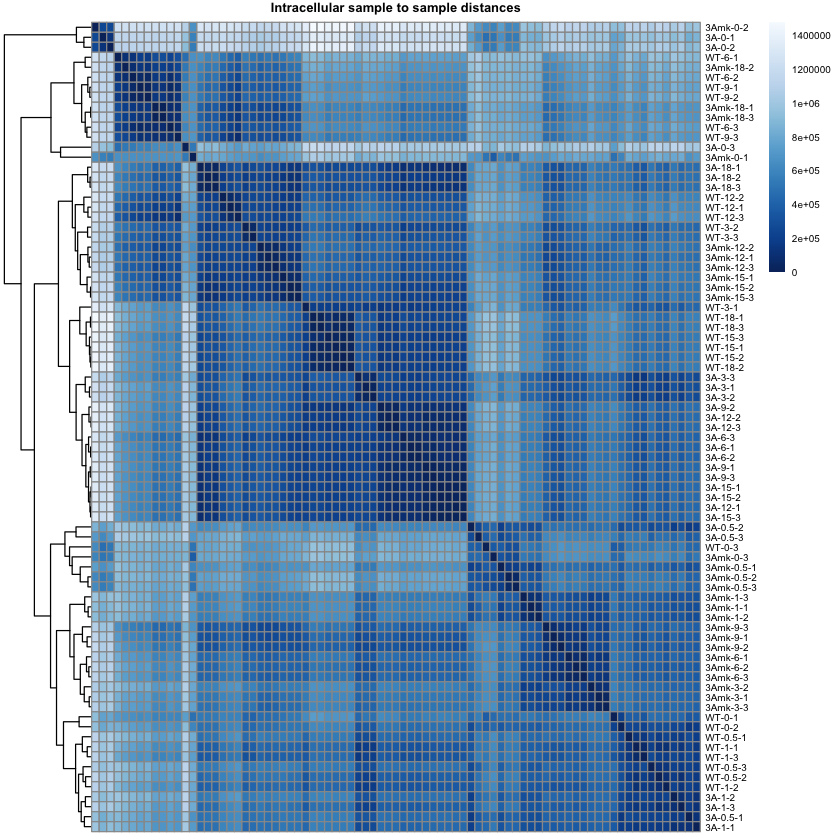

In [4]:
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
sampleDists <- dist(t(MetInt))
sampleDistMatrix <- as.matrix(sampleDists)
colnames(sampleDistMatrix) <- NULL
rownames(sampleDistMatrix) <- colnames(MetInt)
pheatmap(sampleDistMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, col=colors,
         treeheight_col = 0, fontsize = 6, main="Intracellular sample to sample distances")

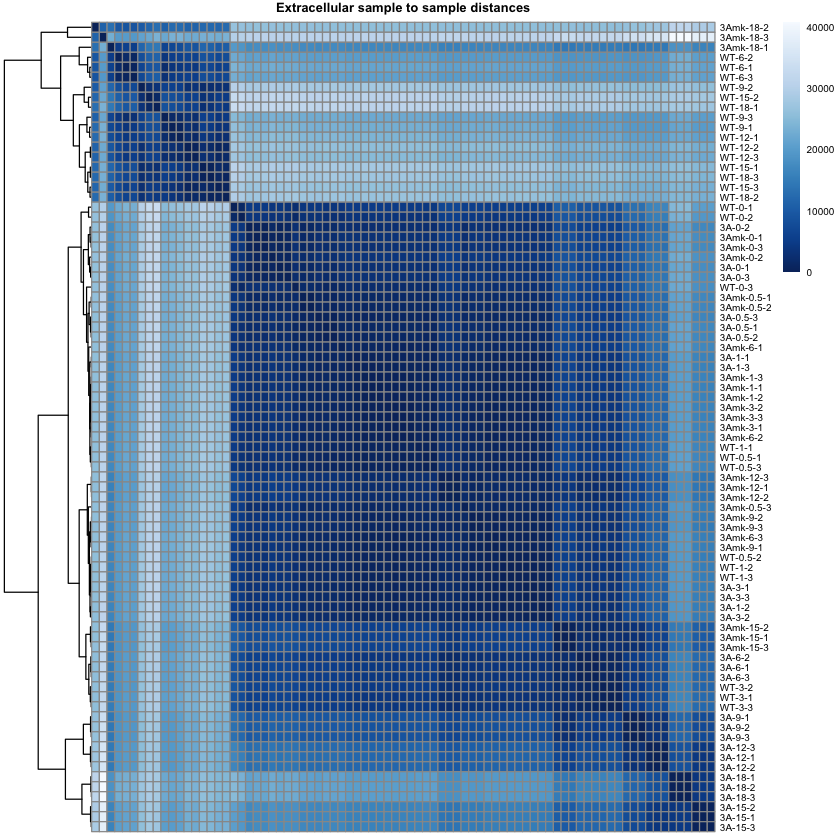

In [5]:
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
sampleDists <- dist(t(MetExt))
sampleDistMatrix <- as.matrix(sampleDists)
colnames(sampleDistMatrix) <- NULL
rownames(sampleDistMatrix) <- colnames(MetExt)
pheatmap(sampleDistMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, col=colors,
         treeheight_col = 0, fontsize = 6, main="Extracellular sample to sample distances")

#### Plot heatmaps

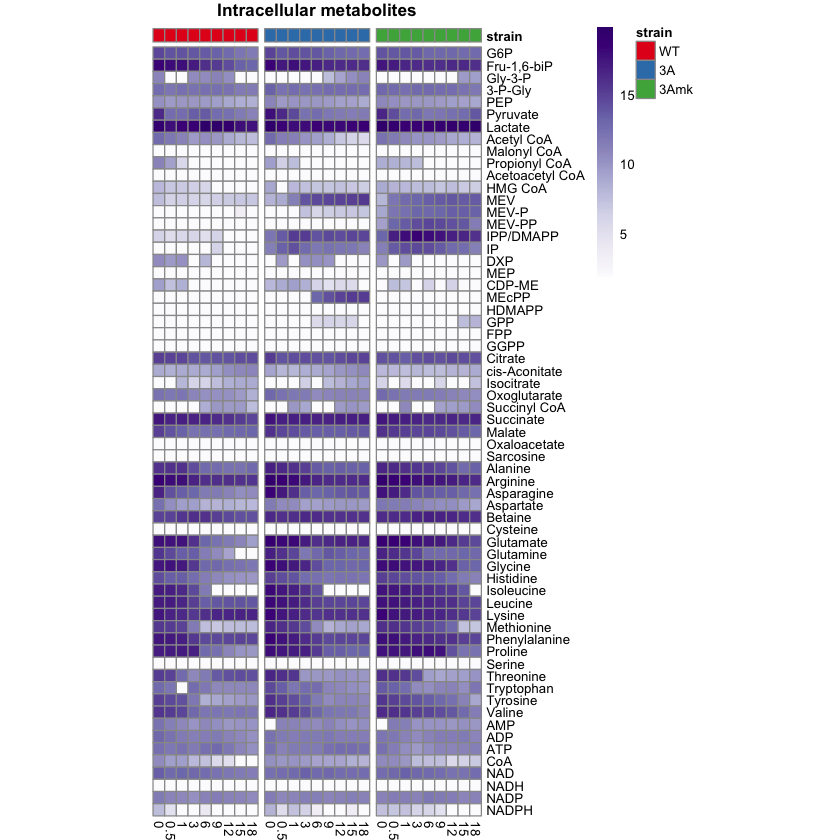

In [6]:
# Do not show Isopentenyl-ATP data and remove outlier 3A 0hr rep3 
Data <- MetInt[!rownames(MetInt) %in% c('Isopentenyl-ATP'),-c(30)]

Avg_df <- setNames(unique(paste0(colData[,1],'-',colData[,2])),unique(paste0(colData[,1],'-',colData[,2])))
Data <- do.call(cbind, lapply(Avg_df, function(x) rowMeans(Data[,substr(colnames(Data),1,nchar(colnames(Data))-2) == x], na.rm=T)))
col_df <- do.call(rbind, lapply(Avg_df, function(x) unique(colData[substr(rownames(colData),1,nchar(rownames(colData))-2) == x,1:2])))

MetInt_Avg <- log2(Data+min(Data[Data>0])/2)

ann_colors <- list(strain = setNames(brewer.pal(3,"Set1"),unique(colData$strain)))

met_int_list <- c('G6P','Fru-1,6-biP','Gly-3-P','3-P-Gly','PEP','Pyruvate','Lactate','Acetyl CoA','Malonyl CoA','Propionyl CoA','Acetoacetyl CoA','HMG CoA','MEV','MEV-P','MEV-PP','IPP/DMAPP','IP','DXP','MEP','CDP-ME','MEcPP','HDMAPP','GPP','FPP','GGPP','Citrate','cis-Aconitate','Isocitrate','Oxoglutarate','Succinyl CoA','Succinate','Malate','Oxaloacetate','Sarcosine','Alanine','Arginine','Asparagine','Aspartate','Betaine','Cysteine','Glutamate','Glutamine','Glycine','Histidine','Isoleucine','Leucine','Lysine','Methionine','Phenylalanine','Proline','Serine','Threonine','Tryptophan','Tyrosine','Valine','AMP','ADP','ATP','CoA','NAD','NADH','NADP','NADPH')
pheatmap(MetInt_Avg[met_int_list,], cluster_rows=FALSE, cluster_cols=FALSE, show_colnames=T, fontsize = 8, cellwidth = 7, 
         color = colorRampPalette(brewer.pal(9,'Purples'))(100), annotation_colors = ann_colors,
         annotation_col=col_df[,1,drop=F], labels_col = col_df$time, gaps_col=c(9,18),
         main="Intracellular metabolites")
pheatmap(MetInt_Avg[met_int_list,], cluster_rows=FALSE, cluster_cols=FALSE, show_colnames=T, fontsize = 8, cellwidth = 7, 
         color = colorRampPalette(brewer.pal(9,'Purples'))(100), annotation_colors = ann_colors,
         annotation_col=col_df[,1,drop=F], labels_col = col_df$time, gaps_col=c(9,18),
         main="Intracellular metabolites", filename="./results/IPP_Metabolomics_Int.pdf")

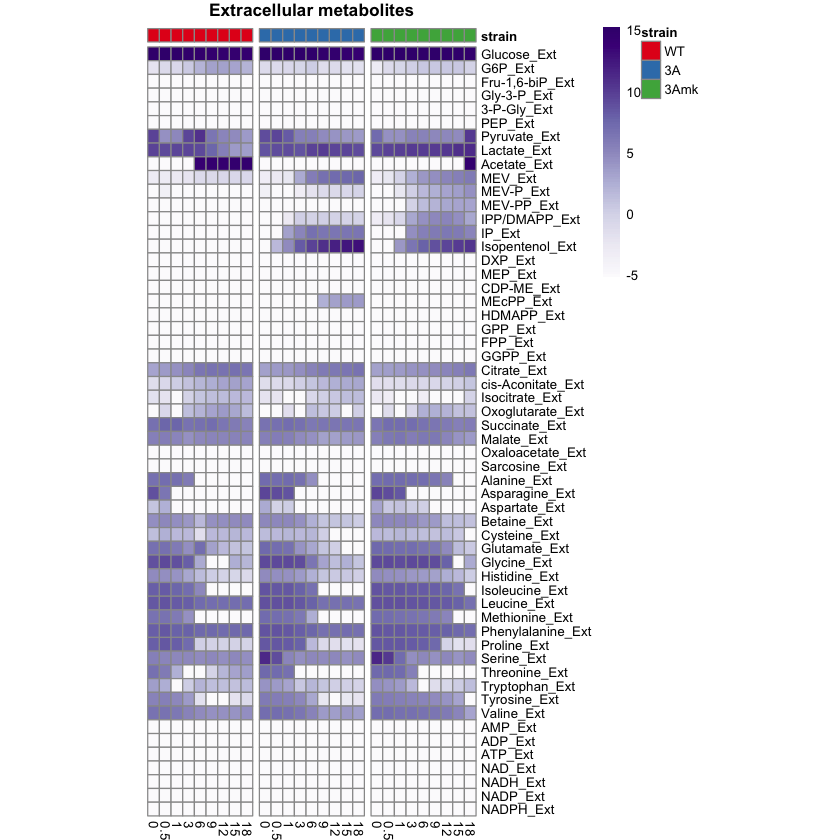

In [7]:
# Remove outlier glucose concentration in strain 3Amk rep2 and rep3 at 18hr 
Data <- MetExt
Data['Glucose_Ext',c(80:81)] <- NA

Avg_df <- setNames(unique(paste0(colData[,1],'-',colData[,2])),unique(paste0(colData[,1],'-',colData[,2])))
Data <- do.call(cbind, lapply(Avg_df, function(x) rowMeans(Data[,substr(colnames(Data),1,nchar(colnames(Data))-2) == x], na.rm=T)))
col_df <- do.call(rbind, lapply(Avg_df, function(x) unique(colData[substr(rownames(colData),1,nchar(rownames(colData))-2) == x,1:2])))

MetExt_Avg <- log2(Data+min(Data[Data>0])/2)

ann_colors <- list(strain = setNames(brewer.pal(3,"Set1"),unique(colData$strain)))

met_ext_list <- c('Glucose_Ext','G6P_Ext','Fru-1,6-biP_Ext','Gly-3-P_Ext','3-P-Gly_Ext','PEP_Ext','Pyruvate_Ext','Lactate_Ext','Acetate_Ext','MEV_Ext','MEV-P_Ext','MEV-PP_Ext','IPP/DMAPP_Ext','IP_Ext','Isopentenol_Ext','DXP_Ext','MEP_Ext','CDP-ME_Ext','MEcPP_Ext','HDMAPP_Ext','GPP_Ext','FPP_Ext','GGPP_Ext','Citrate_Ext','cis-Aconitate_Ext','Isocitrate_Ext','Oxoglutarate_Ext','Succinate_Ext','Malate_Ext','Oxaloacetate_Ext','Sarcosine_Ext','Alanine_Ext','Asparagine_Ext','Aspartate_Ext','Betaine_Ext','Cysteine_Ext','Glutamate_Ext','Glycine_Ext','Histidine_Ext','Isoleucine_Ext','Leucine_Ext','Methionine_Ext','Phenylalanine_Ext','Proline_Ext','Serine_Ext','Threonine_Ext','Tryptophan_Ext','Tyrosine_Ext','Valine_Ext','AMP_Ext','ADP_Ext','ATP_Ext','NAD_Ext','NADH_Ext','NADP_Ext','NADPH_Ext')
pheatmap(MetExt_Avg[met_ext_list,], cluster_rows=FALSE, cluster_cols=FALSE, show_colnames=T, fontsize = 8, cellwidth = 7, 
         color = colorRampPalette(brewer.pal(9,'Purples'))(100), annotation_colors = ann_colors,
         annotation_col=col_df[,1,drop=F], labels_col = col_df$time, gaps_col=c(9,18),
         main="Extracellular metabolites")
pheatmap(MetExt_Avg[met_ext_list,], cluster_rows=FALSE, cluster_cols=FALSE, show_colnames=T, fontsize = 8, cellwidth = 7, 
         color = colorRampPalette(brewer.pal(9,'Purples'))(100), annotation_colors = ann_colors,
         annotation_col=col_df[,1,drop=F], labels_col = col_df$time, gaps_col=c(9,18),
         main="Extracellular metabolites", filename="./results/IPP_Metabolomics_Ext.pdf")

#### Principal component analysis

Intracellular Metabolomics PCA biplot

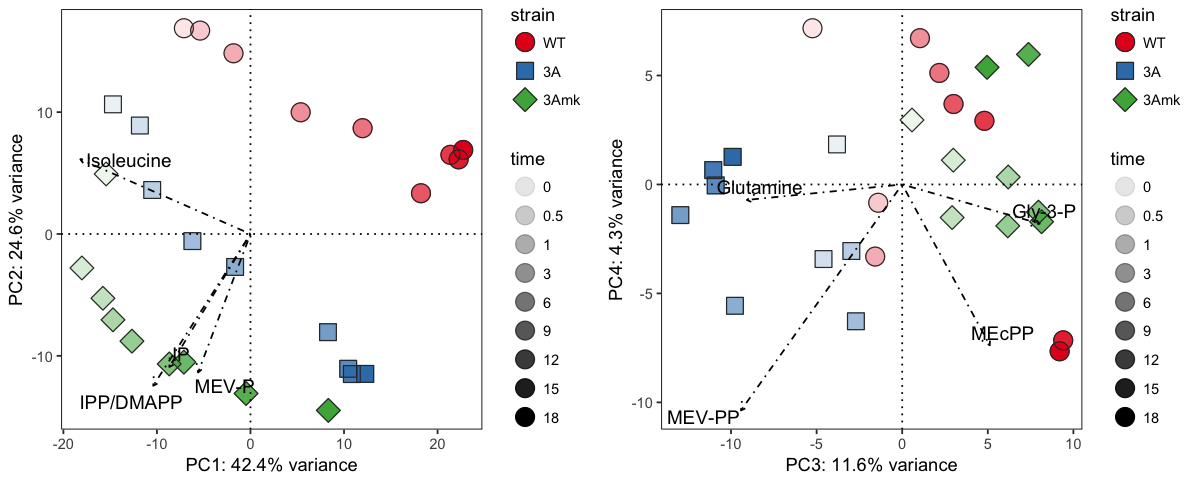

In [8]:
options(repr.plot.width=10, repr.plot.height=4)
plots <- list()
k <- 2
for (pc in 1:k){
    plots[[pc]] <- plotPCA2(MetInt_Avg, col_df, pcs=c(2*pc-1,2*pc), color='time', shape='strain', ntop=4)
}
biplot <- cowplot::plot_grid(plotlist = plots, ncol=2)
cowplot::save_plot("./results/PCA_Metabolomics_Int_Biplot.pdf", biplot, nrow=1, ncol=2, base_aspect_ratio = 1.2)
biplot
options(repr.plot.width=7, repr.plot.height=7)

Intracellular Metabolomics PCA contribution

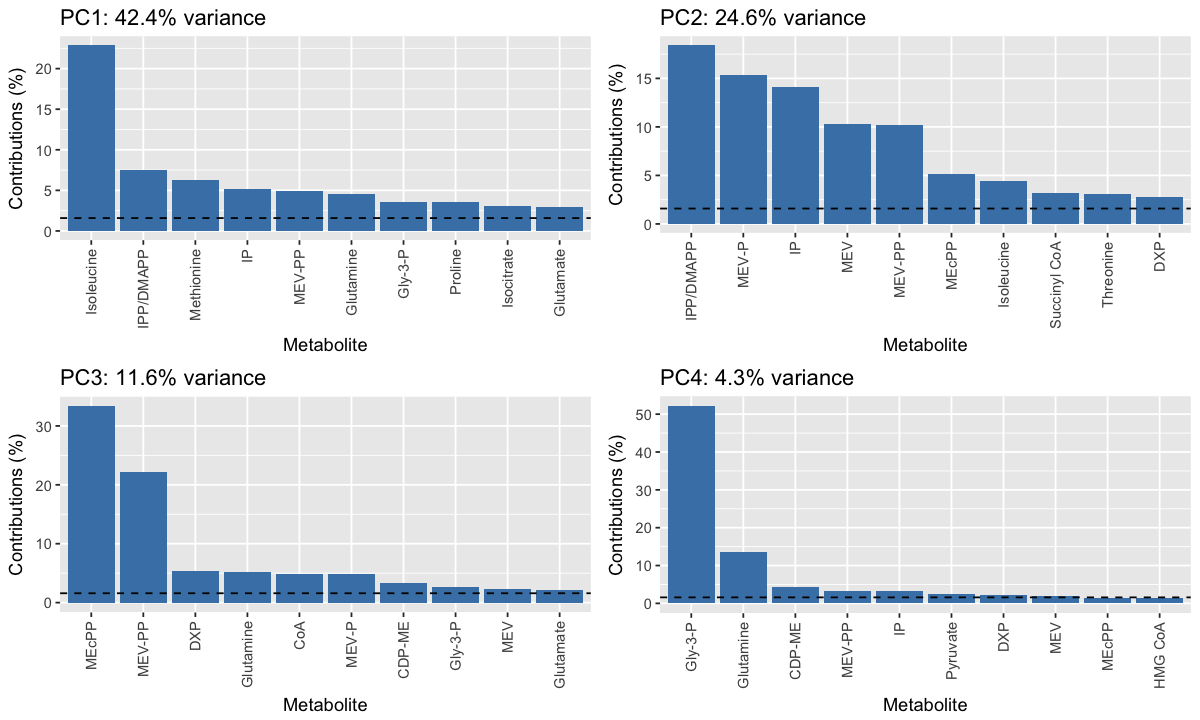

In [9]:
PCA_data <- plotPCA2(MetInt_Avg, col_df, pcs=c(1,2), color='time', shape='strain', returnData = T)
PCA_percentVar <- attr(PCA_data, 'percentVar')
PCA_contrib <- attr(PCA_data, 'contrib')

options(repr.plot.width=10, repr.plot.height=6)
plots <- list()
k <- 4
ntop <- 10
for (pc in 1:k){
    x <- PCA_contrib[order(PCA_contrib[,pc],decreasing = T)[1:ntop],pc]
    contrib_data <- data.frame(Gene = factor(names(x), levels=names(x)), Contrib = x)
    plots[[pc]] <- ggplot() + geom_bar(data = contrib_data[,1:2], stat = "identity", aes(x=Gene, y=Contrib), fill='steelblue') +
                   geom_hline(yintercept=100/nrow(PCA_contrib), linetype=2) +
                   theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5)) +
                   labs(title = paste0("PC",pc,": ", round(PCA_percentVar[pc] * 100,1), "% variance"),
                        x = "Metabolite", y = "Contributions (%)")
}
biplot <- cowplot::plot_grid(plotlist = plots, ncol=2)
cowplot::save_plot("./results/PCA_Metabolomics_Int_Contributions.pdf", biplot, nrow=1, ncol=2, base_aspect_ratio = 1.2)
biplot
options(repr.plot.width=7, repr.plot.height=7)

Extracellular Metabolomics PCA biplot

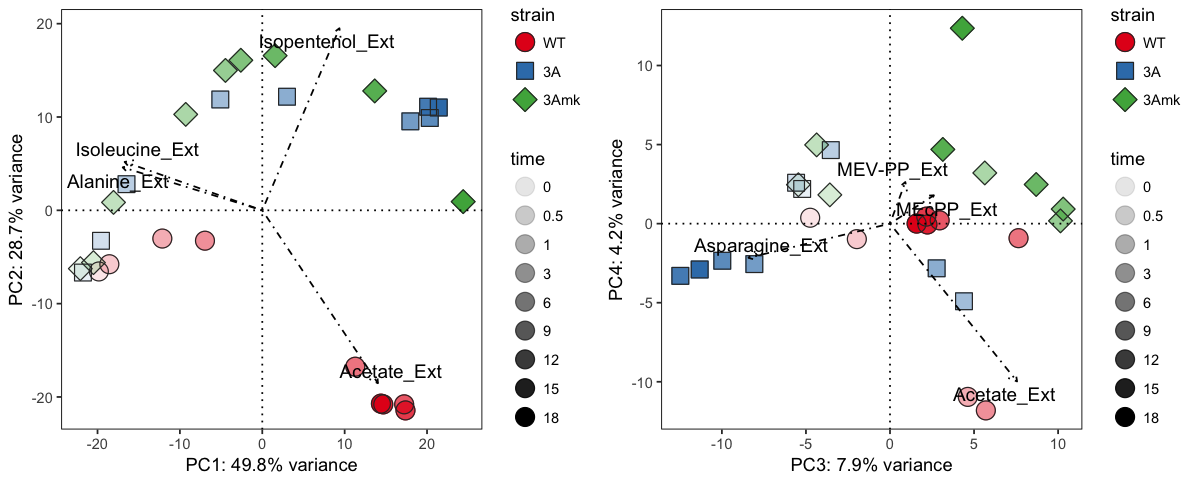

In [10]:
options(repr.plot.width=10, repr.plot.height=4)
plots <- list()
k <- 2
for (pc in 1:k){
    plots[[pc]] <- plotPCA2(MetExt_Avg, col_df, pcs=c(2*pc-1,2*pc), color='time', shape='strain', ntop=4)
}
biplot <- cowplot::plot_grid(plotlist = plots, ncol=2)
cowplot::save_plot("./results/PCA_Metabolomics_Ext_Biplot.pdf", biplot, nrow=1, ncol=2, base_aspect_ratio = 1.2)
biplot
options(repr.plot.width=7, repr.plot.height=7)

Extracellular Metabolomics PCA contribution

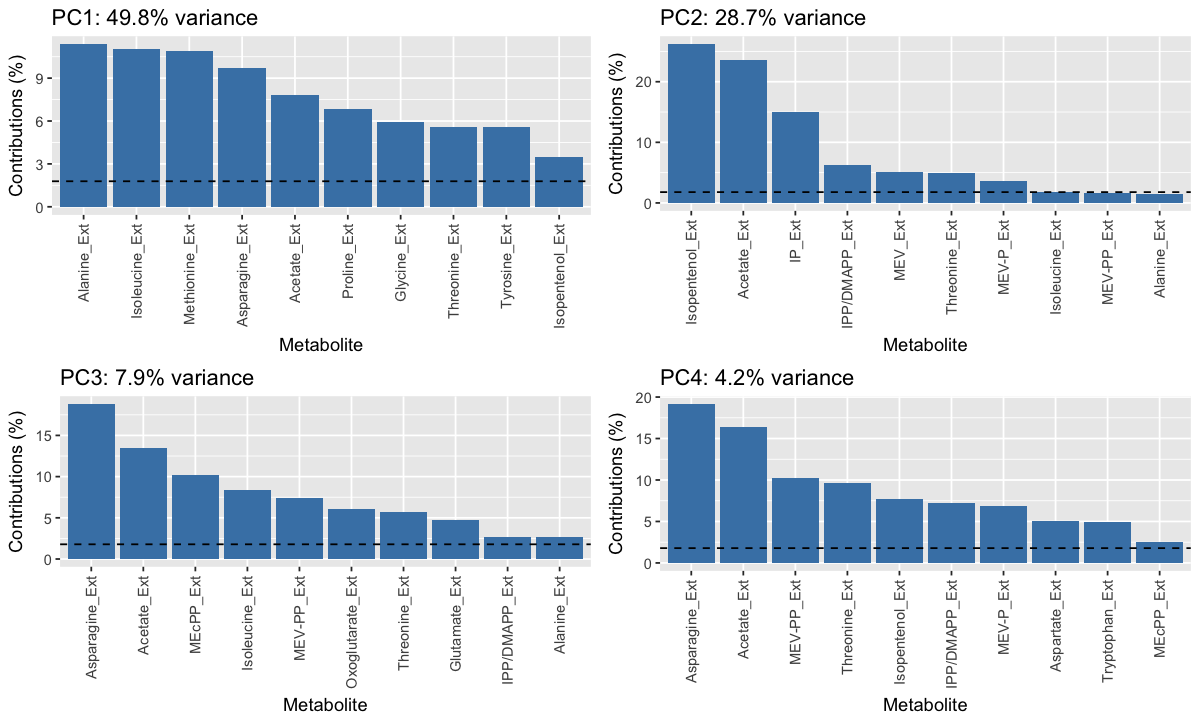

In [11]:
PCA_data <- plotPCA2(MetExt_Avg, col_df, pcs=c(1,2), color='time', shape='strain', returnData = T)
PCA_percentVar <- attr(PCA_data, 'percentVar')
PCA_contrib <- attr(PCA_data, 'contrib')

options(repr.plot.width=10, repr.plot.height=6)
plots <- list()
k <- 4
ntop <- 10
for (pc in 1:k){
    x <- PCA_contrib[order(PCA_contrib[,pc],decreasing = T)[1:ntop],pc]
    contrib_data <- data.frame(Gene = factor(names(x), levels=names(x)), Contrib = x)
    plots[[pc]] <- ggplot() + geom_bar(data = contrib_data[,1:2], stat = "identity", aes(x=Gene, y=Contrib), fill='steelblue') +
                   geom_hline(yintercept=100/nrow(PCA_contrib), linetype=2) +
                   theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5)) +
                   labs(title = paste0("PC",pc,": ", round(PCA_percentVar[pc] * 100,1), "% variance"),
                        x = "Metabolite", y = "Contributions (%)")
}
biplot <- cowplot::plot_grid(plotlist = plots, ncol=2)
cowplot::save_plot("./results/PCA_Metabolomics_Ext_Avg_Contributions.pdf", biplot, nrow=1, ncol=2, base_aspect_ratio = 1.2)
biplot
options(repr.plot.width=7, repr.plot.height=7)